<>:178: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:178: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
/var/folders/rg/06cq00bd6_s_yhndgzq_knlr0000gn/T/ipykernel_47695/835121622.py:178: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
  plt.suptitle("3D Angular Probability Distributions ($w_{lm} \propto |Y_{lm}|^2$)", y=1.05)


正在生成图 4.10 复现图...


/var/folders/rg/06cq00bd6_s_yhndgzq_knlr0000gn/T/ipykernel_47695/835121622.py:26: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  Y_lm = sph_harm(m, l, phi, theta)


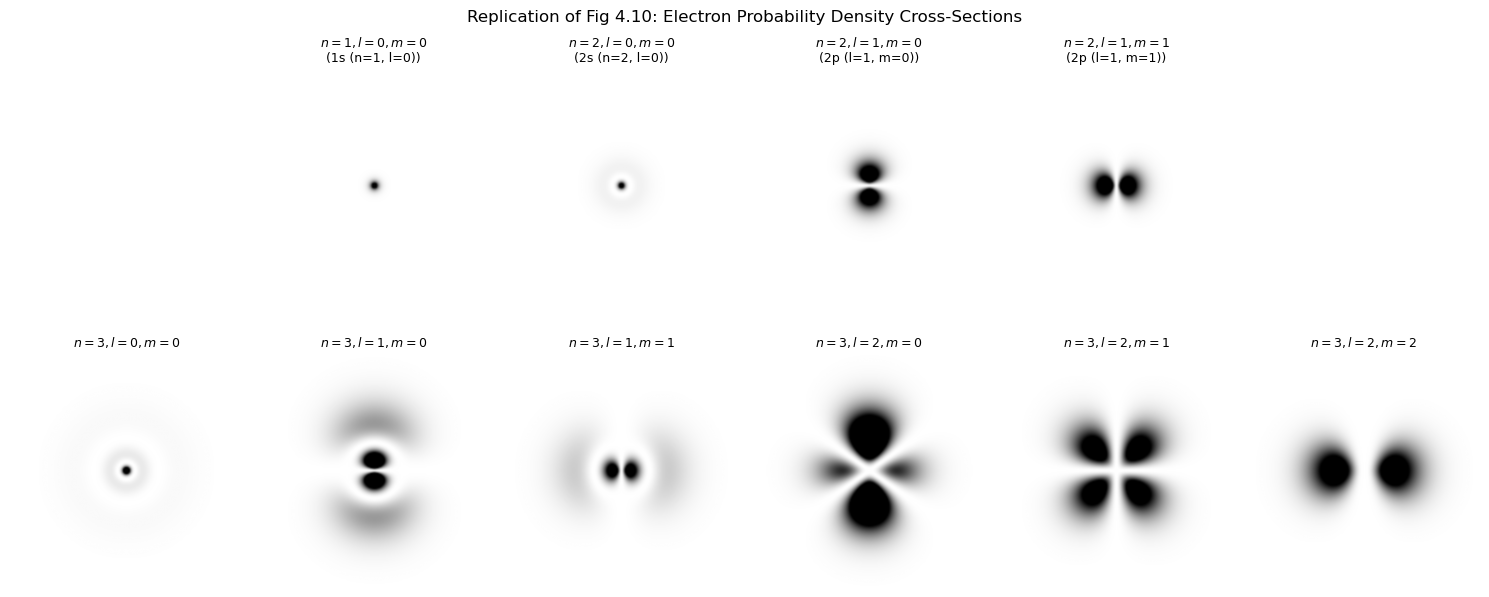

正在生成 3D 轨道示意图...


/var/folders/rg/06cq00bd6_s_yhndgzq_knlr0000gn/T/ipykernel_47695/835121622.py:153: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  Y = sph_harm(m, l, PHI, THETA)


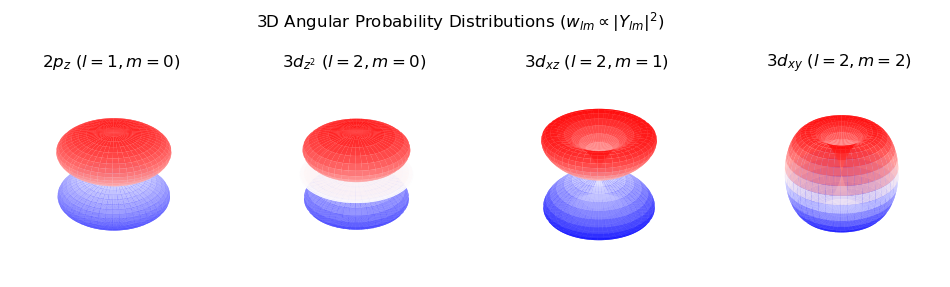

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm, genlaguerre
from matplotlib.colors import LinearSegmentedColormap

# --- 1. 定义物理模型 ---

def hydrogen_wavefunc(n, l, m, r, theta, phi):
    """
    计算氢原子归一化波函数 psi_nlm(r, theta, phi)
    注：这里为了可视化，省略了部分归一化常数，重点在于形状分布。
    """
    # 玻尔半径，设为1用于无量纲绘图
    a0 = 1.0
    
    # 径向部分 R_nl(r)
    # 归一化系数 (简化)
    rho = 2 * r / (n * a0)
    # 广义拉盖尔多项式 L_{n-l-1}^{2l+1}
    L = genlaguerre(n - l - 1, 2 * l + 1)
    R_nl = np.exp(-rho / 2) * (rho ** l) * L(rho)
    
    # 角向部分 Y_lm(theta, phi)
    # scipy的sph_harm参数顺序是 (m, l, phi, theta)
    # 注意：物理中通常 theta是极角(0-pi)，phi是方位角(0-2pi)
    Y_lm = sph_harm(m, l, phi, theta)
    
    psi = R_nl * Y_lm
    return psi

def probability_density(n, l, m, r, theta, phi):
    psi = hydrogen_wavefunc(n, l, m, r, theta, phi)
    return np.abs(psi)**2

# --- 2. 复现图 4.10 (2D 截面) ---

def plot_fig_4_10():
    # 定义要绘制的态 (n, l, m)
    # 上排: 1s, 2s, 2p(m=0), 2p(m=1)
    row1_states = [
        (1, 0, 0, "1s (n=1, l=0)"),
        (2, 0, 0, "2s (n=2, l=0)"),
        (2, 1, 0, "2p (l=1, m=0)"),
        (2, 1, 1, "2p (l=1, m=1)")
    ]
    
    # 下排: 3s, 3p(m=0), 3p(m=1), 3d(m=0), 3d(m=1), 3d(m=2)
    row2_states = [
        (3, 0, 0, "3s (n=3, l=0)"),
        (3, 1, 0, "3p (l=1, m=0)"),
        (3, 1, 1, "3p (l=1, m=±1)"),
        (3, 2, 0, "3d (l=2, m=0)"),
        (3, 2, 1, "3d (l=2, m=±1)"),
        (3, 2, 2, "3d (l=2, m=±2)")
    ]

    # 设置绘图网格
    # 即使上排只有4个，为了对齐方便，我们设最大列数为6
    fig = plt.figure(figsize=(15, 6))
    
    # 自定义灰度图，白色为背景，黑色为高概率 (对应书本印刷风格)
    cmap = LinearSegmentedColormap.from_list("print_style", ["white", "black"])

    # 创建坐标网格 (xz平面, y=0 => phi=0 或 pi)
    limit = 25 # 绘图范围
    points = 200
    x = np.linspace(-limit, limit, points)
    z = np.linspace(-limit, limit, points)
    X, Z = np.meshgrid(x, z)
    
    # 坐标转换: 笛卡尔 -> 球坐标
    # 在xz平面上: r = sqrt(x^2 + z^2), theta = arccos(z/r), phi = 0 (x>0) or pi (x<0)
    R = np.sqrt(X**2 + Z**2)
    Theta = np.arctan2(np.sqrt(X**2), Z) # arctan2处理象限，但在xz平面通常直接用arccos(z/r)
    # 这里简化处理phi：x>0 phi=0, x<0 phi=pi
    Phi = np.where(X >= 0, 0, np.pi)

    # 辅助绘图函数
    def plot_subplot(index, state, total_rows, total_cols, plot_offset=0):
        n, l, m, label = state
        ax = fig.add_subplot(total_rows, total_cols, index + plot_offset)
        
        # 计算密度
        dens = probability_density(n, l, m, R, Theta, Phi)
        
        # 绘制
        # 使用幂律归一化来增强低概率区域的对比度，让云图看清楚
        ax.imshow(dens, extent=[-limit, limit, -limit, limit], 
                  cmap=cmap, origin='lower', interpolation='bicubic',
                  norm=plt.Normalize(vmin=0, vmax=np.max(dens)*0.6))
        
        ax.set_title(f"n={n}, l={l}, m={m}", fontsize=10)
        ax.axis('off')

    # 绘制第一排 (居中显示4个，或者左对齐)
    # 原图上排4个，下排6个。我们用 GridSpec 或者简单的 subplot
    # 这里为了代码简单，直接硬编码位置
    
    # 上排 4 个图
    for i, state in enumerate(row1_states):
        # 安排在 2行6列 的网格中，第一行稍微居中一点
        # 这是一个简单的黑客式布局，为了模拟书本对齐
        loc = i + 2 # 从第2列开始画
        ax = plt.subplot(2, 6, loc) 
        dens = probability_density(*state[:3], R, Theta, Phi)
        ax.imshow(dens, extent=[-limit, limit, -limit, limit], 
                  cmap=cmap, origin='lower', interpolation='bicubic',
                  norm=plt.Normalize(vmin=0, vmax=np.max(dens)*0.5))
        ax.set_title(f"$n={state[0]}, l={state[1]}, m={state[2]}$\n({state[3]})", fontsize=9)
        ax.axis('off')

    # 下排 6 个图
    for i, state in enumerate(row2_states):
        loc = i + 7 # 从第7个位置开始 (第二行第一个)
        ax = plt.subplot(2, 6, loc)
        dens = probability_density(*state[:3], R, Theta, Phi)
        # m=0的态通常很亮，稍微调整对比度
        vmax_scale = 0.3 if state[2] == 0 else 0.6
        ax.imshow(dens, extent=[-limit, limit, -limit, limit], 
                  cmap=cmap, origin='lower', interpolation='bicubic',
                  norm=plt.Normalize(vmin=0, vmax=np.max(dens)*vmax_scale))
        ax.set_title(f"$n={state[0]}, l={state[1]}, m={state[2]}$", fontsize=9)
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle("Replication of Fig 4.10: Electron Probability Density Cross-Sections", y=1.02)
    plt.show()

# --- 3. 3D 轨道可视化 (角向分布/轨道形状) ---

def plot_3d_orbitals():
    """
    绘制几个代表性的3D轨道形状。
    通常绘制 r = |Y_lm|^2 的表面来表示轨道的'形状'。
    """
    states_to_show = [
        (2, 1, 0, "2p_z"), 
        (3, 2, 0, "3d_{z^2}"), 
        (3, 2, 1, "3d_{xz}"),
        (3, 2, 2, "3d_{xy}")
    ]
    
    fig = plt.figure(figsize=(12, 3))
    
    theta = np.linspace(0, np.pi, 100)
    phi = np.linspace(0, 2*np.pi, 100)
    THETA, PHI = np.meshgrid(theta, phi)
    
    for i, (n, l, m, label) in enumerate(states_to_show):
        ax = fig.add_subplot(1, 4, i+1, projection='3d')
        
        # 计算球谐函数
        Y = sph_harm(m, l, PHI, THETA)
        
        # 轨道形状半径 r 这里的定义通常有两种：
        # 1. r = |Y_lm|^2 (角向概率分布) -> 即使是复数Y_lm也是实数形状
        # 2. r = |Re(Y_lm)|^2 (实轨道，化学常用)
        # 物理书通常展示 |Y_lm|^2
        R = np.abs(Y)**2 
        
        # 转换为笛卡尔坐标
        X = R * np.sin(THETA) * np.cos(PHI)
        Y_cart = R * np.sin(THETA) * np.sin(PHI)
        Z = R * np.cos(THETA)

        # 绘图
        # 使用颜色映射相位或者简单的单一颜色
        cmap = plt.cm.bwr
        norm = plt.Normalize(-np.max(R), np.max(R))
        
        ax.plot_surface(X, Y_cart, Z, cmap=cmap, linewidth=0, antialiased=True, alpha=0.8)
        
        # 调整视角
        ax.view_init(elev=30, azim=45)
        ax.set_title(f"${label}$ ($l={l}, m={m}$)")
        ax.axis('off')
        
    plt.suptitle("3D Angular Probability Distributions ($w_{lm} \propto |Y_{lm}|^2$)", y=1.05)
    plt.show()

if __name__ == "__main__":
    print("正在生成图 4.10 复现图...")
    plot_fig_4_10()
    print("正在生成 3D 轨道示意图...")
    plot_3d_orbitals()